In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import time
from keras import layers
from keras import models
from keras import optimizers
from keras import callbacks
from keras import backend as K
from sklearn import model_selection
from sklearn import preprocessing
import pathlib

Using TensorFlow backend.


In [3]:
COORDINATES = ["Xmin", "Ymin", "Xmax", "Ymax"]

In [4]:
answers = pd.read_csv("../raw/train_answers.csv").set_index("itemId")
answers.columns = COORDINATES
scaler = preprocessing.StandardScaler().fit(np.vstack([answers.values, answers.values[:, [2, 3, 0, 1]]]))
answers[COORDINATES] = scaler.transform(answers[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [5]:
votes = pd.read_csv("../raw/train_data.csv").set_index("itemId")
votes[COORDINATES] = scaler.transform(votes[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [6]:
votes_test = pd.read_csv("../raw/test_data.csv").set_index("itemId")
votes_test[COORDINATES] = scaler.transform(votes_test[COORDINATES])

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64 were all converted to float64 by StandardScaler.
  


In [7]:
def find_center(y):
    center_x = (y[0, 2] + y[0, 0]) / 2
    center_y = (y[0, 3] + y[0, 1]) / 2 
    return np.array([center_x, center_y, center_x, center_y])


def scale(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    err_x, err_y = np.random.random(2)  
    
    err_x = 1 + (2 * err_x - 1) * err
    err_y = 1 + (2 * err_y - 1) * err
    
    err = np.array([err_x, err_y, err_x, err_y])
    
    return (x * np.reshape(err, (1, 1, 4)) + np.reshape(center, (1, 1, 4)), 
            y * np.reshape(err, (1, 4)) + np.reshape(center, (1, 4)))
    

def move(x, y, err=0.1):
    center = find_center(y)
    x, y = x - np.reshape(center, (1, 1, 4)), y - np.reshape(center, (1, 4))
    
    size_x = (y[0, 2] - y[0, 0]) / 2
    size_y = (y[0, 3] - y[0, 1]) / 2
    
    err_cx, err_cy = np.random.random(2)  
    
    err_cx = (2 * size_x * err_cx - size_x) * err
    err_cy = (2 * size_y * err_cy - size_y) * err
    
    err = np.array([err_cx, err_cy, err_cx, err_cy])
    
    return x + np.reshape(err + center, (1, 1, 4)), y + np.reshape(err + center, (1, 4))
    
def aug_batch(x, y, err=0.1):
    x, y = scale(x, y, err)
    x, y = move(x, y, err)
    return x, y

In [8]:
def yield_batch(data, batch):
    votes, answers = data
    counts = votes[["userId"]].groupby("itemId").count()
    feat = votes.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = list(set(votes.index))
    while True:
        item_id = np.random.choice(item_ids, batch)
        x = feat.loc[item_id]
        y = answers.loc[item_id]
        yield x, y

In [20]:
def yield_batch_val(data):
    votes, answers = data
    counts = votes[["userId"]].groupby("itemId").count()
    feat = votes.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = list(set(votes.index))
    while True:
        x = feat.loc[item_ids]
        y = answers.loc[item_ids]
        yield x, y

In [10]:
def yield_batch_test(data):
    counts = data[["userId"]].groupby("itemId").count()
    feat = data.groupby("itemId")[COORDINATES].agg(["min", "max", "std", "median", "mean"])
    feat["count"] = counts
    item_ids = data.index.unique()
    for item_id in item_ids:
        x = feat.loc[[item_id]]
        yield x

In [11]:
def intersection_over_union(boxes_pred, boxes_true):

    x_min = K.stack([boxes_pred[:, 0], boxes_true[:, 0]], axis=-1)
    y_min = K.stack([boxes_pred[:, 1], boxes_true[:, 1]], axis=-1)
    x_max = K.stack([boxes_pred[:, 2], boxes_true[:, 2]], axis=-1)
    y_max = K.stack([boxes_pred[:, 3], boxes_true[:, 3]], axis=-1)

    x_min = K.max(x_min, axis=-1)
    y_min = K.max(y_min, axis=-1)
    x_max = K.min(x_max, axis=-1)
    y_max = K.min(y_max, axis=-1)

    zeros = K.zeros_like(x_max)

    x_inter = K.stack([zeros, x_max - x_min], axis=-1)
    y_inter = K.stack([zeros, y_max - y_min], axis=-1)

    x_inter = K.max(x_inter, axis=-1)
    y_inter = K.max(y_inter, axis=-1)
    inter_area = x_inter * y_inter
    
    area_pred = (K.max(K.stack([zeros, boxes_pred[:, 2] - boxes_pred[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_pred[:, 3] - boxes_pred[:, 1]], axis=-1), axis=-1))
    area_true = (K.max(K.stack([zeros, boxes_true[:, 2] - boxes_true[:, 0]], axis=-1), axis=-1) * 
                 K.max(K.stack([zeros, boxes_true[:, 3] - boxes_true[:, 1]], axis=-1), axis=-1))

    iou = inter_area / (area_pred + area_true - inter_area + K.epsilon())
    
    return -K.mean(iou, axis=-1)

In [12]:
def make_model(units):
    K.clear_session()
    
    y = x = layers.Input(shape=(21,))
    
    y = layers.Dense(
        units=units * 8,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 4,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units * 2,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=units,
        activation="relu"
    )(y)
    y = layers.Dense(
        units=4,
        activation=None
    )(y)
    
    model = models.Model(inputs=x, outputs=y)
    model.summary()
    return model

In [13]:
class MaxLRTest(callbacks.Callback):

    def __init__(self, base_lr=1.0e-9, max_lr=10, steps=10000):
        super().__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.steps = steps
        
        self.iterations = None
        self.history = None
        
    def clr(self):
        return self.base_lr * (self.max_lr / self.base_lr) ** (self.iterations / self.steps) 
  
    def on_train_begin(self, logs=None):
        self.iterations = 0
        self.history = {}
        K.set_value(self.model.optimizer.lr, self.base_lr)     
            
    def on_batch_end(self, batch, logs=None):
        if self.iterations > self.steps:
            self.model.stop_training = True
        
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.clr())
        
    def plot(self, smooth=None, t_score=2):
        smooth = int(smooth or self.steps // 10)
        df = pd.DataFrame(self.history).set_index("lr").loss.rolling(smooth).agg(["mean", "std"])
        df["std"] = df["mean"] + t_score * df["std"] / smooth ** 0.5
        print(f"Max speed learning rate  - {df['std'].idxmin():.1e}")
        df.plot(logx=True, figsize=(16, 8))

In [14]:
class DecayingLR(callbacks.Callback):

    def __init__(self, max_lr=0.1, warm_up=1, decay_per_epoch=1):
        super().__init__()

        self.max_lr = max_lr
        self.warm_up = warm_up
        self.decay_per_epoch = decay_per_epoch
        
        self.iterations = None
        self.history = None
        
        self.d_loss_iterations = None
        self.d_loss = None
        self.d_iterations = None
        self.d_iterations2 = None
        self.d_1 = None
                
        self.steps = None
        self.decay = None

    def on_train_begin(self, logs=None):
        self.iterations = 1
        self.history = {}
        
        self.d_loss_iterations = 0
        self.d_loss = 0
        self.d_iterations = 0
        self.d_iterations2 = 0
        self.d_1 = 0
        
        self.steps = self.params["steps"]
        self.decay = (1 - 1 / self.steps) ** (1 / self.decay_per_epoch)
        
        K.set_value(self.model.optimizer.lr, self.lr())
    
    def make_decay(self, old, new):
        decay = self.decay
        return old * decay + new * (1 - decay)
    
    def lr(self):
        warm_up = self.iterations / self.steps * self.warm_up
        if warm_up <= 1:
            return self.max_lr * warm_up 
        
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        
        if speed > 0:
            return lr * self.decay
        
        return lr
            
    def on_batch_end(self, batch, logs=None):
        self.history.setdefault("iterations", []).append(self.iterations)
        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
            
        self.d_loss_iterations = self.make_decay(self.d_loss_iterations, logs["loss"] * self.iterations)
        self.d_loss = self.make_decay(self.d_loss, logs["loss"])
        self.d_iterations = self.make_decay(self.d_iterations, self.iterations)
        self.d_iterations2 = self.make_decay(self.d_iterations2, self.iterations ** 2)
        self.d_1 = self.make_decay(self.d_1, 1)
        
        cov = self.d_loss_iterations - self.d_loss * self.d_iterations / self.d_1
        var = self.d_iterations2 - self.d_iterations ** 2 / self.d_1
        
        speed = self.steps * cov / var
        self.history.setdefault("speed", []).append(speed)
        
        self.iterations += 1
        K.set_value(self.model.optimizer.lr, self.lr())     
        
    def on_epoch_end(self, epoch, logs=None):
        lr = self.history["lr"][-1]
        speed = self.history["speed"][-1]
        print(f"Learning rate: {lr:.1e}")
        print(f"Speed per epoch: {speed:.4f}")
        print()
        
    def plot(self, smooth=None):
        smooth = int(smooth or self.steps)
        df = pd.DataFrame(self.history).set_index("iterations")[["loss", "lr"]].rolling(smooth).mean()
        df.plot(figsize=(16, 8), secondary_y="lr")

In [15]:
def train_model(data_train, data_val, units, batch, test=False):
    
    max_lr = 3.9e-03
    
    steps_per_epoch = 1000 // batch
    epochs = 100
    
    model = make_model(units)  
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr / 100, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                      loss="mae",
                      metrics=[intersection_over_union]
        )
    rez = model.fit_generator(
            yield_batch(data_train, batch),
            steps_per_epoch=1000,
            epochs=1,
            callbacks=None,
            validation_data=yield_batch_val(data_val),
            validation_steps=1,
        )
    
    
    model.compile(optimizer=optimizers.Nadam(lr=max_lr, beta_1=0.9, beta_2=0.999, epsilon=None, schedule_decay=0.004),
                  loss=intersection_over_union,
                  metrics=None
    )
    cycle = MaxLRTest() if test else DecayingLR(max_lr=max_lr)
    cb = [
        callbacks.ModelCheckpoint("../processed/model1.h5", monitor="val_loss", verbose=1, save_best_only=True),
        cycle
    ]
    rez = model.fit_generator(
        yield_batch(data_train, batch),
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        callbacks=cb,
        validation_data=yield_batch_val(data_val),
        validation_steps=1,
        )
    
    model = models.load_model("../processed/model1.h5", custom_objects={"intersection_over_union": intersection_over_union})
    
    return rez, cycle, model

In [16]:
FOLDS = 10

def train_oof(train_set, test_set, units=16, batch=1):
    x_train, y_train = train_set
    x_test = test_set

    y_oof = pd.DataFrame(0, index=y_train.index, columns=COORDINATES)
    y_pred = pd.DataFrame(0, index=x_test.index.unique(), columns=COORDINATES)
    scores = []
    folds = model_selection.KFold(n_splits=FOLDS, shuffle=True)
    
    for n, (index_train, index_valid) in enumerate(folds.split(y_train), 1):
        print(f"\nFold - {n} / {FOLDS}")
        
        ids_train = y_train.index[index_train]
        ids_valid = y_train.index[index_valid]
        
        data_train = (x_train.loc[ids_train], y_train.loc[ids_train])
        data_val = (x_train.loc[ids_valid], y_train.loc[ids_valid])
        
        rez, cycle, model = train_model(data_train, data_val, units, batch)
        
        cycle.plot()
        pd.DataFrame(rez.history)[["loss", "val_loss"]].plot(figsize=(16, 8))
        scores.append(min(rez.history["val_loss"]))
        
        feat = yield_batch_test(data_val[0])
        df = model.predict_generator(feat, steps=len(data_val[0].index.unique()))
        df = scaler.inverse_transform(df)
        y_oof.loc[ids_valid] = df
        
        feat = yield_batch_test(x_test)
        df = model.predict_generator(feat, steps=len(x_test.index.unique()))
        df = scaler.inverse_transform(df)
        y_pred += df / FOLDS

    print(f"IOU на кроссвалидации: " + str(-np.round(sorted(scores), 5)))
    print(f"IOU среднее: {-np.mean(scores):0.5f} +/- {np.std(scores):0.5f}")

    subdir = time.strftime('%Y-%m-%d_%H-%M')
    path = pathlib.Path(f"../processed/{subdir}")
    path.mkdir(exist_ok=True)
    y_oof.to_csv(path / f"oof-{-np.mean(scores):0.5f}.csv", header=False)
    y_pred.to_csv(path / f"sub-{-np.mean(scores):0.5f}.csv", header=False)


Fold - 1 / 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 21)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2816      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_4 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 68        
Total params: 13,748
Trainable params: 13,748
Non-trainable params: 0
_________________________________________________________

/Users/WLMike/Documents/PycharmProjects/ML_venv/lib/python3.6/site-packages/ipykernel_launcher.py:70: RuntimeWarning: invalid value encountered in double_scalars


1000/1000 [==============================] - 3s 3ms/step - loss: -0.3272 - val_loss: -0.3460

Epoch 00001: val_loss improved from inf to -0.34597, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.0228

Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.3929 - val_loss: -0.4055

Epoch 00002: val_loss improved from -0.34597 to -0.40550, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.0577

Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4314 - val_loss: -0.3017

Epoch 00003: val_loss did not improve from -0.40550
Learning rate: 3.9e-03
Speed per epoch: -0.0424

Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4344 - val_loss: -0.4616

Epoch 00004: val_loss improved from -0.40550 to -0.46159, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.0264

Epoch 5/100
1000/1000 [==============================]

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5828 - val_loss: -0.5793

Epoch 00037: val_loss did not improve from -0.58137
Learning rate: 6.9e-05
Speed per epoch: -0.0038

Epoch 38/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5728 - val_loss: -0.5818

Epoch 00038: val_loss improved from -0.58137 to -0.58177, saving model to ../processed/model1.h5
Learning rate: 3.4e-05
Speed per epoch: -0.0003

Epoch 39/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5785 - val_loss: -0.5823

Epoch 00039: val_loss improved from -0.58177 to -0.58230, saving model to ../processed/model1.h5
Learning rate: 2.3e-05
Speed per epoch: -0.0005

Epoch 40/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5797 - val_loss: -0.5809

Epoch 00040: val_loss did not improve from -0.58230
Learning rate: 1.4e-05
Speed per epoch: -0.0016

Epoch 41/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5858 - val

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5870 - val_loss: -0.5817

Epoch 00076: val_loss did not improve from -0.58300
Learning rate: 7.3e-13
Speed per epoch: -0.0023

Epoch 77/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5787 - val_loss: -0.5817

Epoch 00077: val_loss did not improve from -0.58300
Learning rate: 4.9e-13
Speed per epoch: 0.0018

Epoch 78/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5905 - val_loss: -0.5817

Epoch 00078: val_loss did not improve from -0.58300
Learning rate: 3.1e-13
Speed per epoch: -0.0047

Epoch 79/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5780 - val_loss: -0.5817

Epoch 00079: val_loss did not improve from -0.58300
Learning rate: 2.1e-13
Speed per epoch: 0.0047

Epoch 80/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5893 - val_loss: -0.5817

Epoch 00080: val_loss did not improve from -0.58300
Learning rate: 1.4e-13
S

1000/1000 [==============================] - 3s 3ms/step - loss: -0.4779 - val_loss: -0.4880

Epoch 00009: val_loss improved from -0.46406 to -0.48797, saving model to ../processed/model1.h5
Learning rate: 2.7e-03
Speed per epoch: -0.0158

Epoch 10/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4800 - val_loss: -0.4987

Epoch 00010: val_loss improved from -0.48797 to -0.49873, saving model to ../processed/model1.h5
Learning rate: 2.7e-03
Speed per epoch: -0.0114

Epoch 11/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4806 - val_loss: -0.5095

Epoch 00011: val_loss improved from -0.49873 to -0.50955, saving model to ../processed/model1.h5
Learning rate: 2.7e-03
Speed per epoch: -0.0079

Epoch 12/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4731 - val_loss: -0.5146

Epoch 00012: val_loss improved from -0.50955 to -0.51460, saving model to ../processed/model1.h5
Learning rate: 2.2e-03
Speed per epoch: -0.0043

E

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5973 - val_loss: -0.5674

Epoch 00046: val_loss improved from -0.56651 to -0.56737, saving model to ../processed/model1.h5
Learning rate: 2.1e-05
Speed per epoch: -0.0016

Epoch 47/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5915 - val_loss: -0.5671

Epoch 00047: val_loss did not improve from -0.56737
Learning rate: 1.1e-05
Speed per epoch: -0.0001

Epoch 48/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5916 - val_loss: -0.5664

Epoch 00048: val_loss did not improve from -0.56737
Learning rate: 7.2e-06
Speed per epoch: 0.0045

Epoch 49/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5938 - val_loss: -0.5663

Epoch 00049: val_loss did not improve from -0.56737
Learning rate: 3.3e-06
Speed per epoch: 0.0031

Epoch 50/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5915 - val_loss: -0.5662

Epoch 00050: val_loss did not i

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5835 - val_loss: -0.5662

Epoch 00085: val_loss did not improve from -0.56737
Learning rate: 3.9e-14
Speed per epoch: 0.0021

Epoch 86/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5905 - val_loss: -0.5662

Epoch 00086: val_loss did not improve from -0.56737
Learning rate: 2.6e-14
Speed per epoch: 0.0005

Epoch 87/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5954 - val_loss: -0.5662

Epoch 00087: val_loss did not improve from -0.56737
Learning rate: 1.9e-14
Speed per epoch: -0.0036

Epoch 88/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5918 - val_loss: -0.5662

Epoch 00088: val_loss did not improve from -0.56737
Learning rate: 1.3e-14
Speed per epoch: -0.0034

Epoch 89/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5847 - val_loss: -0.5662

Epoch 00089: val_loss did not improve from -0.56737
Learning rate: 7.4e-15
S

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5266 - val_loss: -0.5185

Epoch 00016: val_loss did not improve from -0.52626
Learning rate: 2.2e-03
Speed per epoch: -0.0090

Epoch 17/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5046 - val_loss: -0.5083

Epoch 00017: val_loss did not improve from -0.52626
Learning rate: 1.8e-03
Speed per epoch: 0.0046

Epoch 18/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5317 - val_loss: -0.5251

Epoch 00018: val_loss did not improve from -0.52626
Learning rate: 1.2e-03
Speed per epoch: -0.0090

Epoch 19/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5330 - val_loss: -0.5260

Epoch 00019: val_loss did not improve from -0.52626
Learning rate: 1.2e-03
Speed per epoch: -0.0057

Epoch 20/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5343 - val_loss: -0.5434

Epoch 00020: val_loss improved from -0.52626 to -0.54335, saving model to .

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5861 - val_loss: -0.5614

Epoch 00054: val_loss did not improve from -0.56249
Learning rate: 2.2e-08
Speed per epoch: -0.0017

Epoch 55/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5907 - val_loss: -0.5614

Epoch 00055: val_loss did not improve from -0.56249
Learning rate: 2.1e-08
Speed per epoch: 0.0003

Epoch 56/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5895 - val_loss: -0.5614

Epoch 00056: val_loss did not improve from -0.56249
Learning rate: 1.3e-08
Speed per epoch: 0.0002

Epoch 57/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5827 - val_loss: -0.5614

Epoch 00057: val_loss did not improve from -0.56249
Learning rate: 6.4e-09
Speed per epoch: 0.0051

Epoch 58/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5910 - val_loss: -0.5614

Epoch 00058: val_loss did not improve from -0.56249
Learning rate: 4.2e-09
Sp

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5832 - val_loss: -0.5614

Epoch 00094: val_loss did not improve from -0.56249
Learning rate: 2.4e-17
Speed per epoch: 0.0025

Epoch 95/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5781 - val_loss: -0.5614

Epoch 00095: val_loss did not improve from -0.56249
Learning rate: 8.9e-18
Speed per epoch: 0.0052

Epoch 96/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5823 - val_loss: -0.5614

Epoch 00096: val_loss did not improve from -0.56249
Learning rate: 3.3e-18
Speed per epoch: 0.0027

Epoch 97/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5919 - val_loss: -0.5614

Epoch 00097: val_loss did not improve from -0.56249
Learning rate: 2.8e-18
Speed per epoch: -0.0019

Epoch 98/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5824 - val_loss: -0.5614

Epoch 00098: val_loss did not improve from -0.56249
Learning rate: 1.9e-18
Sp

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5491 - val_loss: -0.5710

Epoch 00025: val_loss improved from -0.56607 to -0.57105, saving model to ../processed/model1.h5
Learning rate: 8.4e-04
Speed per epoch: -0.0043

Epoch 26/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5634 - val_loss: -0.5602

Epoch 00026: val_loss did not improve from -0.57105
Learning rate: 8.4e-04
Speed per epoch: -0.0090

Epoch 27/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5451 - val_loss: -0.5802

Epoch 00027: val_loss improved from -0.57105 to -0.58023, saving model to ../processed/model1.h5
Learning rate: 5.6e-04
Speed per epoch: -0.0003

Epoch 28/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5475 - val_loss: -0.5686

Epoch 00028: val_loss did not improve from -0.58023
Learning rate: 2.9e-04
Speed per epoch: -0.0008

Epoch 29/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5647 - val

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5905 - val_loss: -0.5930

Epoch 00062: val_loss did not improve from -0.59317
Learning rate: 4.5e-10
Speed per epoch: -0.0025

Epoch 63/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5805 - val_loss: -0.5930

Epoch 00063: val_loss did not improve from -0.59317
Learning rate: 3.3e-10
Speed per epoch: 0.0013

Epoch 64/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5896 - val_loss: -0.5930

Epoch 00064: val_loss did not improve from -0.59317
Learning rate: 2.7e-10
Speed per epoch: -0.0018

Epoch 65/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5871 - val_loss: -0.5930

Epoch 00065: val_loss did not improve from -0.59317
Learning rate: 2.6e-10
Speed per epoch: -0.0000

Epoch 66/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5834 - val_loss: -0.5930

Epoch 00066: val_loss did not improve from -0.59317
Learning rate: 1.2e-10


Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 0.4786 - intersection_over_union: -0.1876 - val_loss: 0.3552 - val_intersection_over_union: -0.3049
Epoch 1/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.3538 - val_loss: -0.2869

Epoch 00001: val_loss improved from inf to -0.28689, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: 0.0520

Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.3973 - val_loss: -0.4283

Epoch 00002: val_loss improved from -0.28689 to -0.42826, saving model to ../processed/model1.h5
Learning rate: 3.4e-03
Speed per epoch: -0.0396

Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4140 - val_loss: -0.4576

Epoch 00003: val_loss improved from -0.42826 to -0.45757, saving model to ../processed/model1.h5
Learning rate: 3.4e-03
Speed per epoch: -0.0246

Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5780 - val_loss: -0.5397

Epoch 00037: val_loss did not improve from -0.54152
Learning rate: 3.7e-05
Speed per epoch: 0.0000

Epoch 38/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5891 - val_loss: -0.5420

Epoch 00038: val_loss improved from -0.54152 to -0.54197, saving model to ../processed/model1.h5
Learning rate: 2.5e-05
Speed per epoch: -0.0065

Epoch 39/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5958 - val_loss: -0.5370

Epoch 00039: val_loss did not improve from -0.54197
Learning rate: 2.5e-05
Speed per epoch: -0.0055

Epoch 40/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5901 - val_loss: -0.5361

Epoch 00040: val_loss did not improve from -0.54197
Learning rate: 2.3e-05
Speed per epoch: -0.0024

Epoch 41/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.6060 - val_loss: -0.5368

Epoch 00041: val_loss did not 

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5826 - val_loss: -0.5390

Epoch 00076: val_loss did not improve from -0.54197
Learning rate: 2.5e-13
Speed per epoch: 0.0018

Epoch 77/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5990 - val_loss: -0.5390

Epoch 00077: val_loss did not improve from -0.54197
Learning rate: 1.8e-13
Speed per epoch: -0.0056

Epoch 78/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5839 - val_loss: -0.5390

Epoch 00078: val_loss did not improve from -0.54197
Learning rate: 1.3e-13
Speed per epoch: 0.0025

Epoch 79/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5884 - val_loss: -0.5390

Epoch 00079: val_loss did not improve from -0.54197
Learning rate: 6.4e-14
Speed per epoch: 0.0004

Epoch 80/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5864 - val_loss: -0.5390

Epoch 00080: val_loss did not improve from -0.54197
Learning rate: 3.1e-14
Sp

1000/1000 [==============================] - 3s 3ms/step - loss: -0.4602 - val_loss: -0.4365

Epoch 00008: val_loss did not improve from -0.46895
Learning rate: 3.9e-03
Speed per epoch: -0.0050

Epoch 9/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4734 - val_loss: -0.4517

Epoch 00009: val_loss did not improve from -0.46895
Learning rate: 3.9e-03
Speed per epoch: -0.0046

Epoch 10/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4653 - val_loss: -0.4727

Epoch 00010: val_loss improved from -0.46895 to -0.47270, saving model to ../processed/model1.h5
Learning rate: 3.6e-03
Speed per epoch: -0.0010

Epoch 11/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4879 - val_loss: -0.4747

Epoch 00011: val_loss improved from -0.47270 to -0.47470, saving model to ../processed/model1.h5
Learning rate: 3.6e-03
Speed per epoch: -0.0087

Epoch 12/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4969 - val_

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5841 - val_loss: -0.5653

Epoch 00045: val_loss did not improve from -0.56606
Learning rate: 5.1e-06
Speed per epoch: -0.0004

Epoch 46/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5864 - val_loss: -0.5651

Epoch 00046: val_loss did not improve from -0.56606
Learning rate: 4.3e-06
Speed per epoch: 0.0006

Epoch 47/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5897 - val_loss: -0.5651

Epoch 00047: val_loss did not improve from -0.56606
Learning rate: 2.8e-06
Speed per epoch: -0.0035

Epoch 48/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5808 - val_loss: -0.5655

Epoch 00048: val_loss did not improve from -0.56606
Learning rate: 1.6e-06
Speed per epoch: 0.0014

Epoch 49/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5874 - val_loss: -0.5655

Epoch 00049: val_loss did not improve from -0.56606
Learning rate: 8.8e-07
S

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5773 - val_loss: -0.5656

Epoch 00085: val_loss did not improve from -0.56606
Learning rate: 3.4e-15
Speed per epoch: 0.0003

Epoch 86/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5951 - val_loss: -0.5656

Epoch 00086: val_loss did not improve from -0.56606
Learning rate: 3.1e-15
Speed per epoch: -0.0081

Epoch 87/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5753 - val_loss: -0.5656

Epoch 00087: val_loss did not improve from -0.56606
Learning rate: 1.9e-15
Speed per epoch: 0.0028

Epoch 88/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5775 - val_loss: -0.5656

Epoch 00088: val_loss did not improve from -0.56606
Learning rate: 9.7e-16
Speed per epoch: 0.0052

Epoch 89/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5828 - val_loss: -0.5656

Epoch 00089: val_loss did not improve from -0.56606
Learning rate: 4.3e-16
Sp


Epoch 00016: val_loss did not improve from -0.53414
Learning rate: 2.1e-03
Speed per epoch: -0.0012

Epoch 17/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5053 - val_loss: -0.4941

Epoch 00017: val_loss did not improve from -0.53414
Learning rate: 1.4e-03
Speed per epoch: -0.0072

Epoch 18/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5302 - val_loss: -0.5448

Epoch 00018: val_loss improved from -0.53414 to -0.54480, saving model to ../processed/model1.h5
Learning rate: 1.4e-03
Speed per epoch: -0.0132

Epoch 19/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5376 - val_loss: -0.5345

Epoch 00019: val_loss did not improve from -0.54480
Learning rate: 1.4e-03
Speed per epoch: -0.0115

Epoch 20/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5369 - val_loss: -0.5486

Epoch 00020: val_loss improved from -0.54480 to -0.54860, saving model to ../processed/model1.h5
Learning rate: 1.4e-03
Sp

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5907 - val_loss: -0.5723

Epoch 00054: val_loss did not improve from -0.57315
Learning rate: 7.0e-08
Speed per epoch: -0.0015

Epoch 55/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5877 - val_loss: -0.5723

Epoch 00055: val_loss did not improve from -0.57315
Learning rate: 4.4e-08
Speed per epoch: -0.0015

Epoch 56/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5924 - val_loss: -0.5723

Epoch 00056: val_loss did not improve from -0.57315
Learning rate: 3.8e-08
Speed per epoch: -0.0018

Epoch 57/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5916 - val_loss: -0.5723

Epoch 00057: val_loss did not improve from -0.57315
Learning rate: 3.6e-08
Speed per epoch: 0.0004

Epoch 58/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5874 - val_loss: -0.5723

Epoch 00058: val_loss did not improve from -0.57315
Learning rate: 2.1e-08


1000/1000 [==============================] - 3s 3ms/step - loss: -0.5855 - val_loss: -0.5723

Epoch 00094: val_loss did not improve from -0.57315
Learning rate: 4.4e-17
Speed per epoch: -0.0048

Epoch 95/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5848 - val_loss: -0.5723

Epoch 00095: val_loss did not improve from -0.57315
Learning rate: 4.3e-17
Speed per epoch: -0.0010

Epoch 96/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5839 - val_loss: -0.5723

Epoch 00096: val_loss did not improve from -0.57315
Learning rate: 3.4e-17
Speed per epoch: 0.0010

Epoch 97/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5769 - val_loss: -0.5723

Epoch 00097: val_loss did not improve from -0.57315
Learning rate: 1.5e-17
Speed per epoch: 0.0037

Epoch 98/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5838 - val_loss: -0.5723

Epoch 00098: val_loss did not improve from -0.57315
Learning rate: 6.2e-18
S

Learning rate: 6.8e-04
Speed per epoch: -0.0089

Epoch 25/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5571 - val_loss: -0.5281

Epoch 00025: val_loss did not improve from -0.53067
Learning rate: 6.8e-04
Speed per epoch: -0.0033

Epoch 26/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5575 - val_loss: -0.5299

Epoch 00026: val_loss did not improve from -0.53067
Learning rate: 5.7e-04
Speed per epoch: -0.0017

Epoch 27/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5671 - val_loss: -0.5281

Epoch 00027: val_loss did not improve from -0.53067
Learning rate: 5.7e-04
Speed per epoch: -0.0049

Epoch 28/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5589 - val_loss: -0.5326

Epoch 00028: val_loss improved from -0.53067 to -0.53265, saving model to ../processed/model1.h5
Learning rate: 4.8e-04
Speed per epoch: -0.0001

Epoch 29/100
1000/1000 [==============================] - 3s 3ms/step - lo

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5949 - val_loss: -0.5419

Epoch 00063: val_loss did not improve from -0.54273
Learning rate: 1.7e-09
Speed per epoch: -0.0010

Epoch 64/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5918 - val_loss: -0.5419

Epoch 00064: val_loss did not improve from -0.54273
Learning rate: 1.3e-09
Speed per epoch: -0.0007

Epoch 65/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5851 - val_loss: -0.5419

Epoch 00065: val_loss did not improve from -0.54273
Learning rate: 7.5e-10
Speed per epoch: 0.0040

Epoch 66/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5836 - val_loss: -0.5419

Epoch 00066: val_loss did not improve from -0.54273
Learning rate: 2.8e-10
Speed per epoch: 0.0041

Epoch 67/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5897 - val_loss: -0.5419

Epoch 00067: val_loss did not improve from -0.54273
Learning rate: 1.3e-10
S

Epoch 1/1
1000/1000 [==============================] - 3s 3ms/step - loss: 0.5773 - intersection_over_union: -0.1067 - val_loss: 0.4575 - val_intersection_over_union: -0.1728
Epoch 1/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.3503 - val_loss: -0.3796

Epoch 00001: val_loss improved from inf to -0.37962, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.0142

Epoch 2/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.3847 - val_loss: -0.3165

Epoch 00002: val_loss did not improve from -0.37962
Learning rate: 3.9e-03
Speed per epoch: -0.0226

Epoch 3/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4118 - val_loss: -0.4623

Epoch 00003: val_loss improved from -0.37962 to -0.46230, saving model to ../processed/model1.h5
Learning rate: 3.9e-03
Speed per epoch: -0.0257

Epoch 4/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4275 - val_loss: -0.4804

Epoch 00004: 

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5750 - val_loss: -0.5605

Epoch 00037: val_loss improved from -0.55750 to -0.56049, saving model to ../processed/model1.h5
Learning rate: 3.3e-04
Speed per epoch: -0.0003

Epoch 38/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5818 - val_loss: -0.5568

Epoch 00038: val_loss did not improve from -0.56049
Learning rate: 2.2e-04
Speed per epoch: -0.0029

Epoch 39/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5782 - val_loss: -0.5616

Epoch 00039: val_loss improved from -0.56049 to -0.56164, saving model to ../processed/model1.h5
Learning rate: 1.4e-04
Speed per epoch: -0.0007

Epoch 40/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5815 - val_loss: -0.5614

Epoch 00040: val_loss did not improve from -0.56164
Learning rate: 9.1e-05
Speed per epoch: -0.0039

Epoch 41/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5781 - val

1000/1000 [==============================] - 4s 4ms/step - loss: -0.5897 - val_loss: -0.5664

Epoch 00075: val_loss did not improve from -0.56728
Learning rate: 4.1e-12
Speed per epoch: -0.0012

Epoch 76/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5809 - val_loss: -0.5664

Epoch 00076: val_loss did not improve from -0.56728
Learning rate: 1.9e-12
Speed per epoch: 0.0024

Epoch 77/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5912 - val_loss: -0.5664

Epoch 00077: val_loss did not improve from -0.56728
Learning rate: 1.0e-12
Speed per epoch: -0.0056

Epoch 78/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5855 - val_loss: -0.5664

Epoch 00078: val_loss did not improve from -0.56728
Learning rate: 8.7e-13
Speed per epoch: -0.0005

Epoch 79/100
1000/1000 [==============================] - 4s 4ms/step - loss: -0.5832 - val_loss: -0.5664

Epoch 00079: val_loss did not improve from -0.56728
Learning rate: 4.7e-13


1000/1000 [==============================] - 3s 3ms/step - loss: -0.4442 - val_loss: -0.4675

Epoch 00007: val_loss did not improve from -0.47686
Learning rate: 3.3e-03
Speed per epoch: -0.0044

Epoch 8/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4757 - val_loss: -0.4449

Epoch 00008: val_loss did not improve from -0.47686
Learning rate: 3.3e-03
Speed per epoch: -0.0106

Epoch 9/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4727 - val_loss: -0.4835

Epoch 00009: val_loss improved from -0.47686 to -0.48352, saving model to ../processed/model1.h5
Learning rate: 3.3e-03
Speed per epoch: -0.0072

Epoch 10/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4827 - val_loss: -0.4626

Epoch 00010: val_loss did not improve from -0.48352
Learning rate: 3.3e-03
Speed per epoch: -0.0040

Epoch 11/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.4996 - val_loss: -0.4712

Epoch 00011: val_loss did not i

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5849 - val_loss: -0.5511

Epoch 00044: val_loss did not improve from -0.55205
Learning rate: 9.2e-06
Speed per epoch: 0.0011

Epoch 45/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5906 - val_loss: -0.5511

Epoch 00045: val_loss did not improve from -0.55205
Learning rate: 7.3e-06
Speed per epoch: -0.0016

Epoch 46/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5806 - val_loss: -0.5515

Epoch 00046: val_loss did not improve from -0.55205
Learning rate: 3.5e-06
Speed per epoch: 0.0017

Epoch 47/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5829 - val_loss: -0.5513

Epoch 00047: val_loss did not improve from -0.55205
Learning rate: 1.8e-06
Speed per epoch: 0.0021

Epoch 48/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5881 - val_loss: -0.5515

Epoch 00048: val_loss did not improve from -0.55205
Learning rate: 1.1e-06
Sp

1000/1000 [==============================] - 3s 3ms/step - loss: -0.5857 - val_loss: -0.5516

Epoch 00084: val_loss did not improve from -0.55205
Learning rate: 2.9e-14
Speed per epoch: -0.0007

Epoch 85/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5896 - val_loss: -0.5516

Epoch 00085: val_loss did not improve from -0.55205
Learning rate: 2.2e-14
Speed per epoch: -0.0005

Epoch 86/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5884 - val_loss: -0.5516

Epoch 00086: val_loss did not improve from -0.55205
Learning rate: 1.5e-14
Speed per epoch: 0.0009

Epoch 87/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5891 - val_loss: -0.5516

Epoch 00087: val_loss did not improve from -0.55205
Learning rate: 1.0e-14
Speed per epoch: 0.0018

Epoch 88/100
1000/1000 [==============================] - 3s 3ms/step - loss: -0.5817 - val_loss: -0.5516

Epoch 00088: val_loss did not improve from -0.55205
Learning rate: 4.0e-15
S

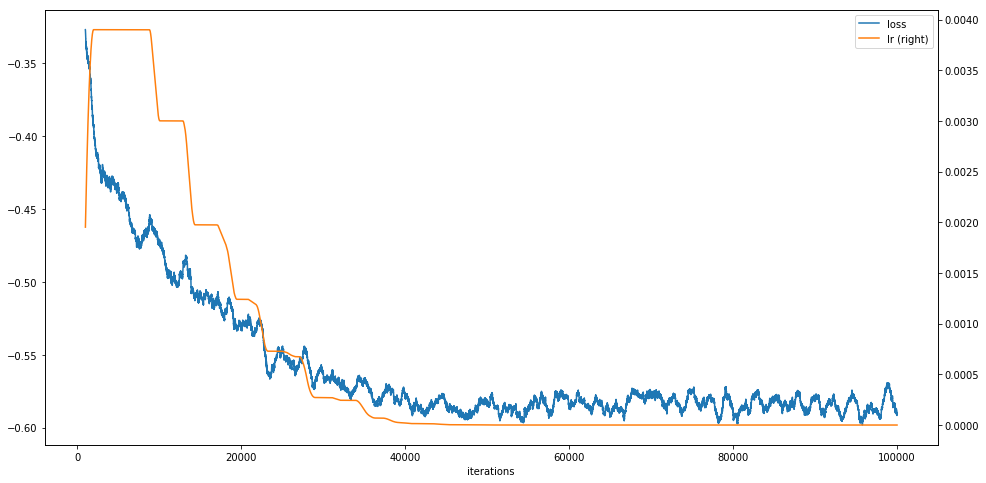

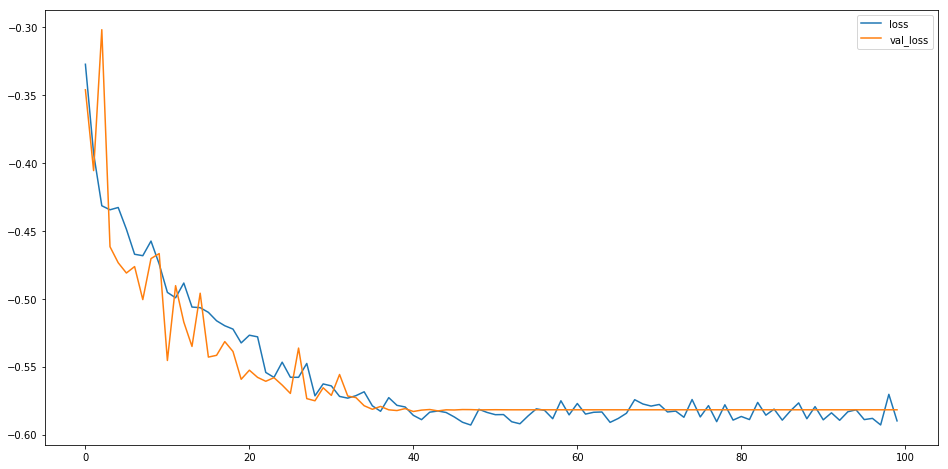

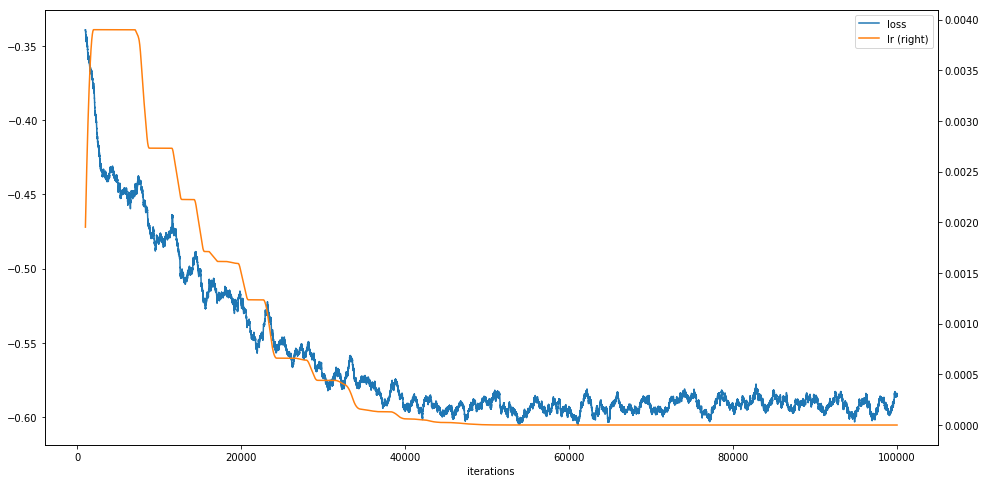

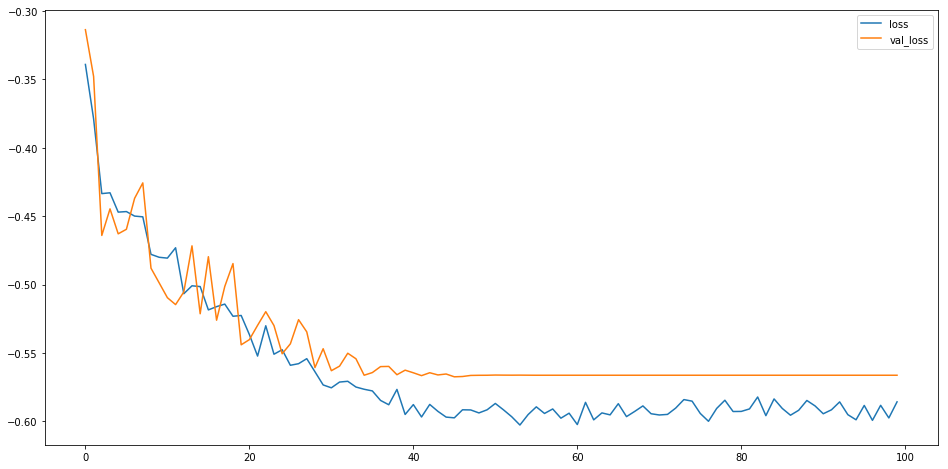

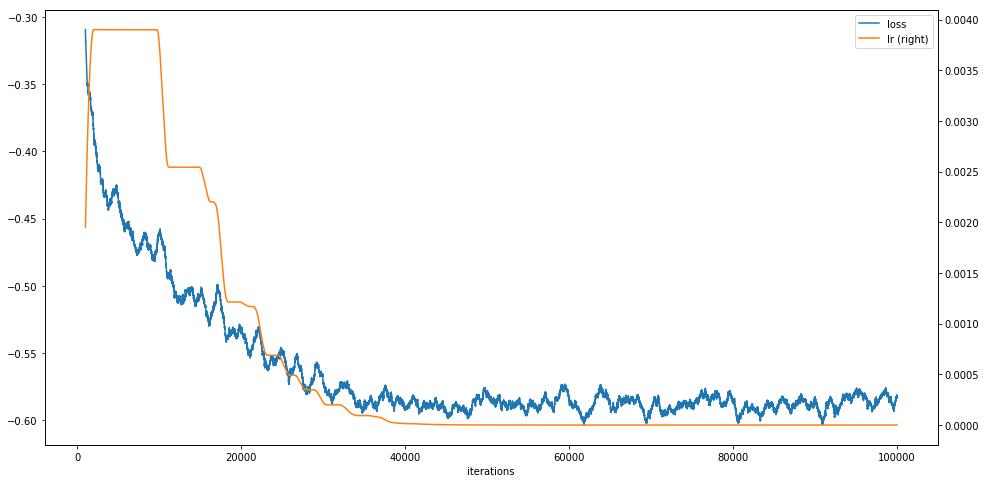

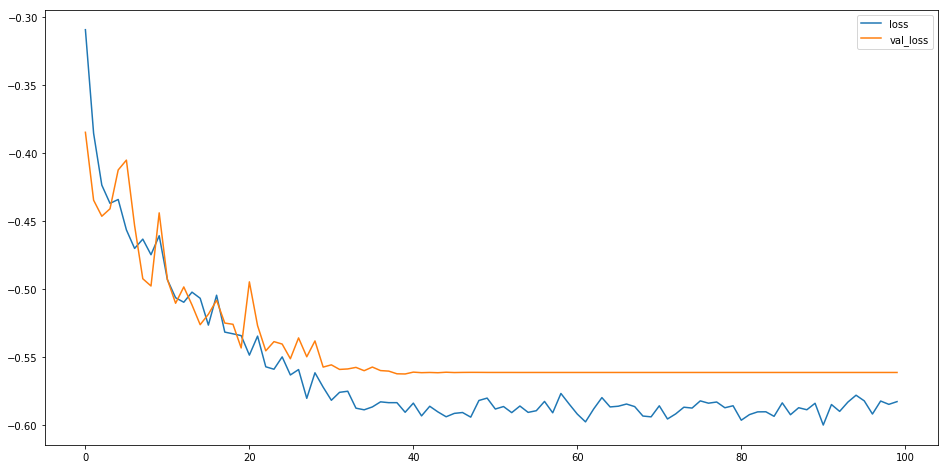

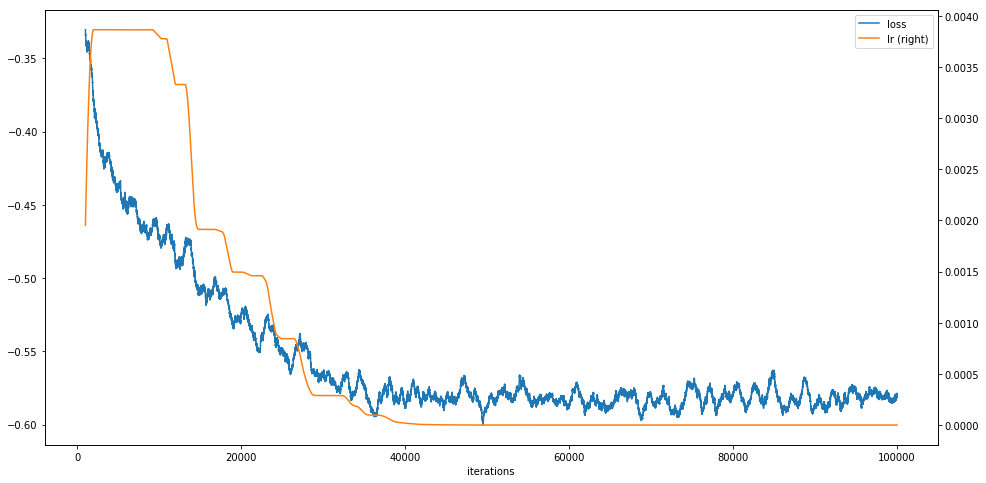

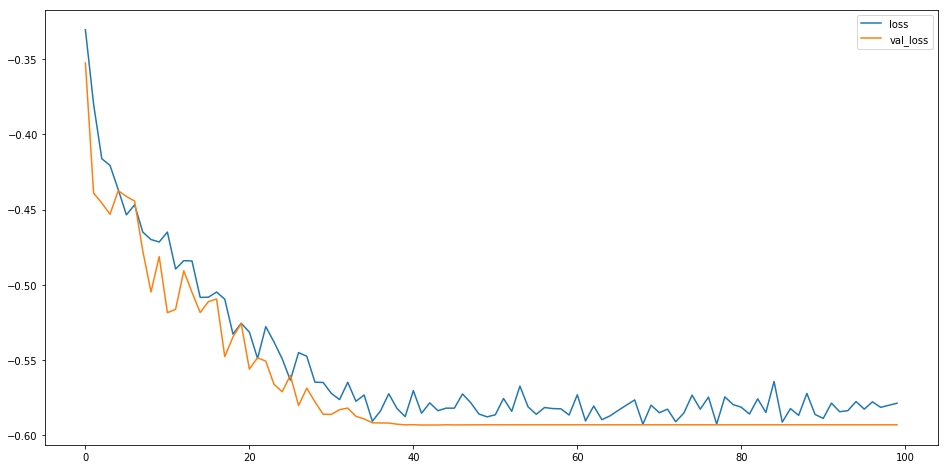

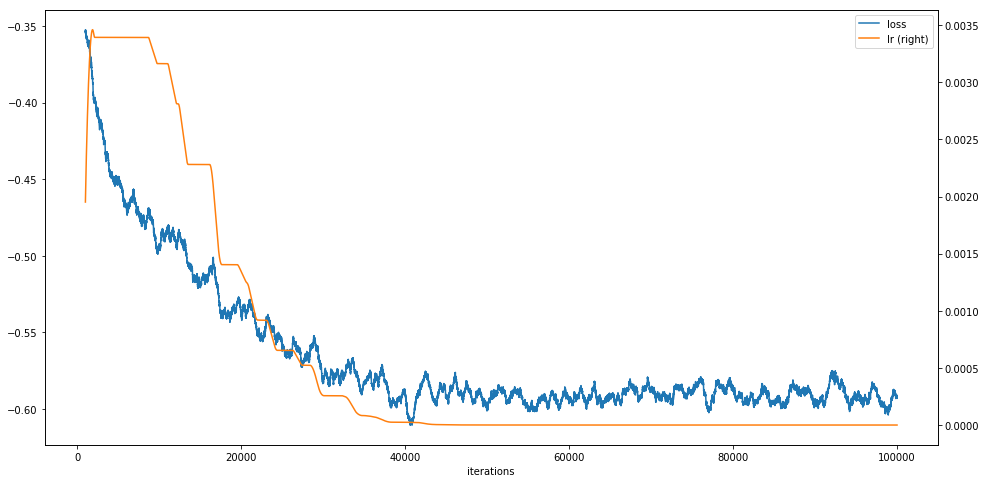

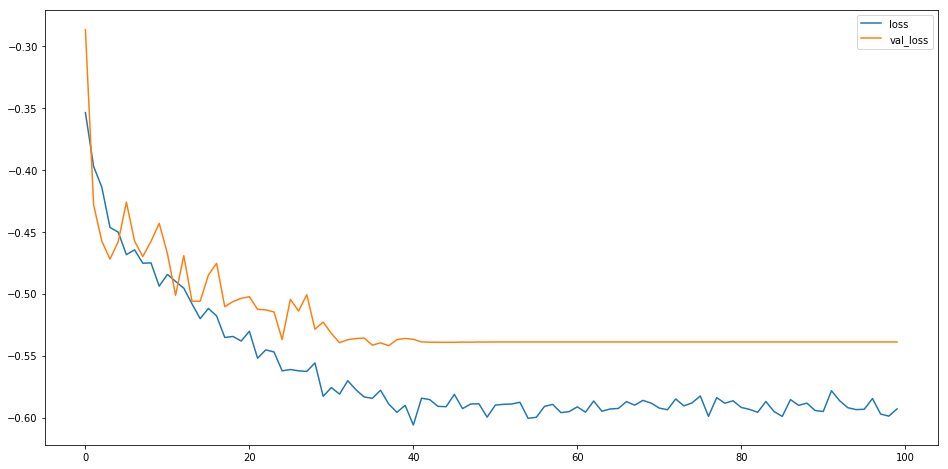

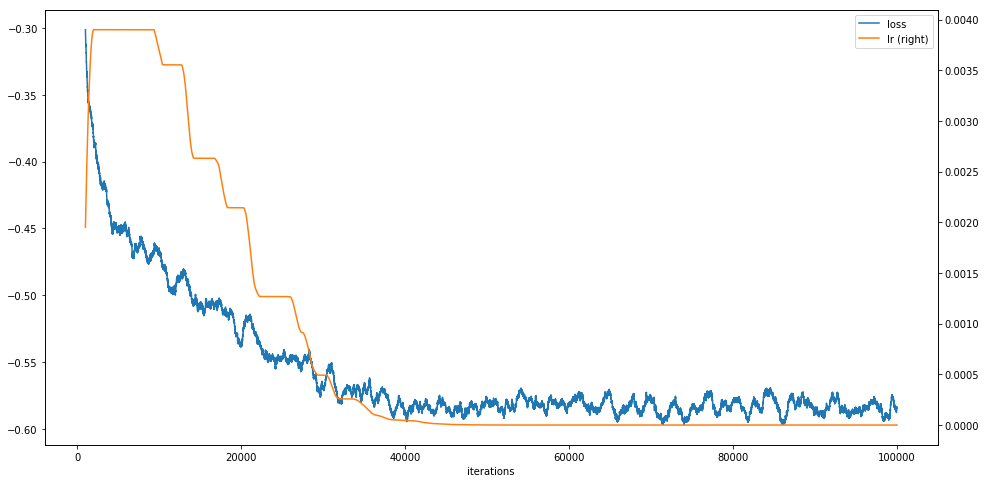

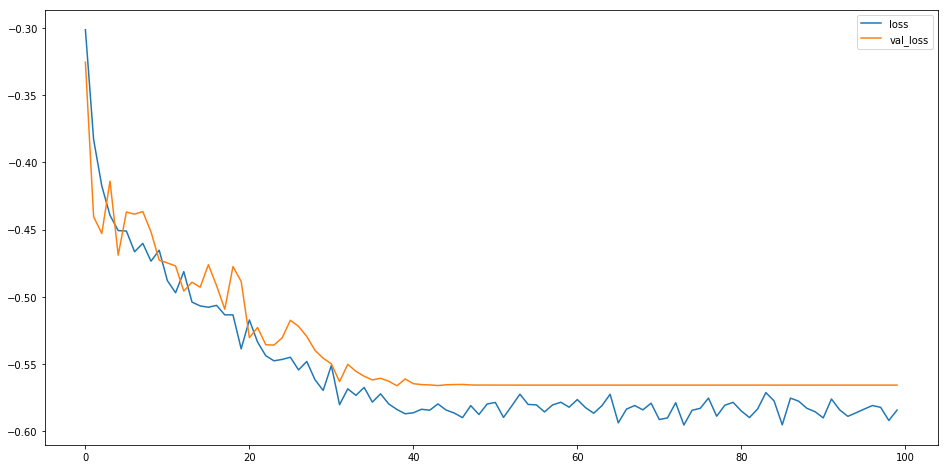

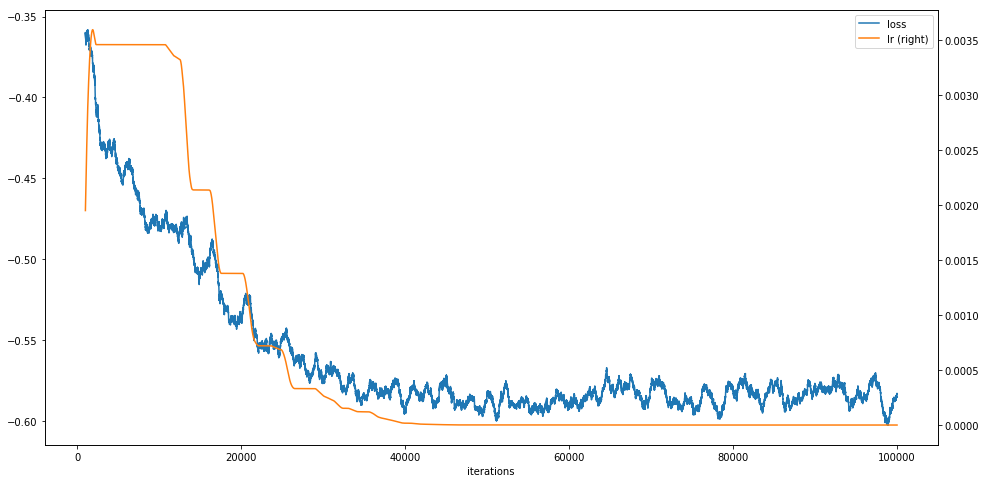

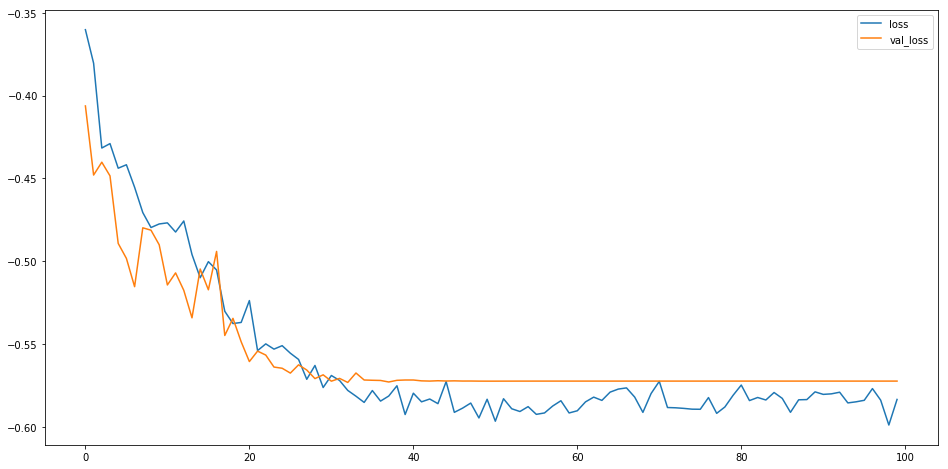

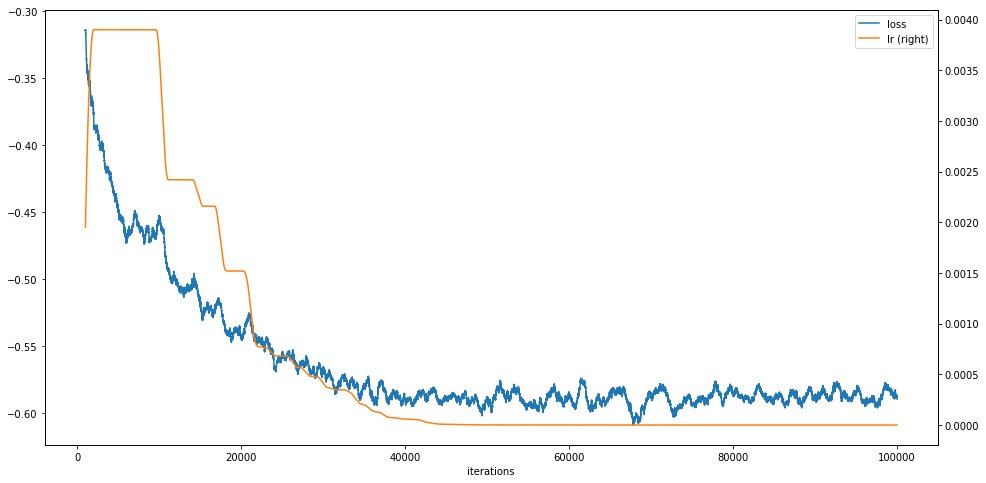

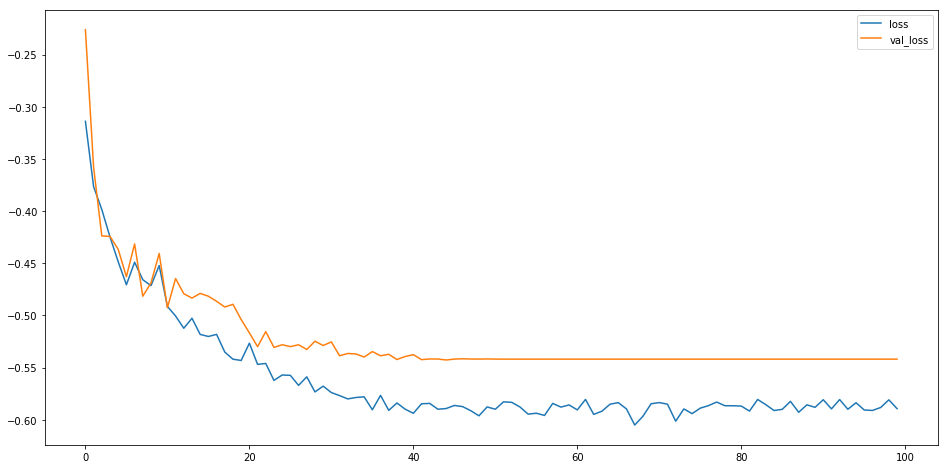

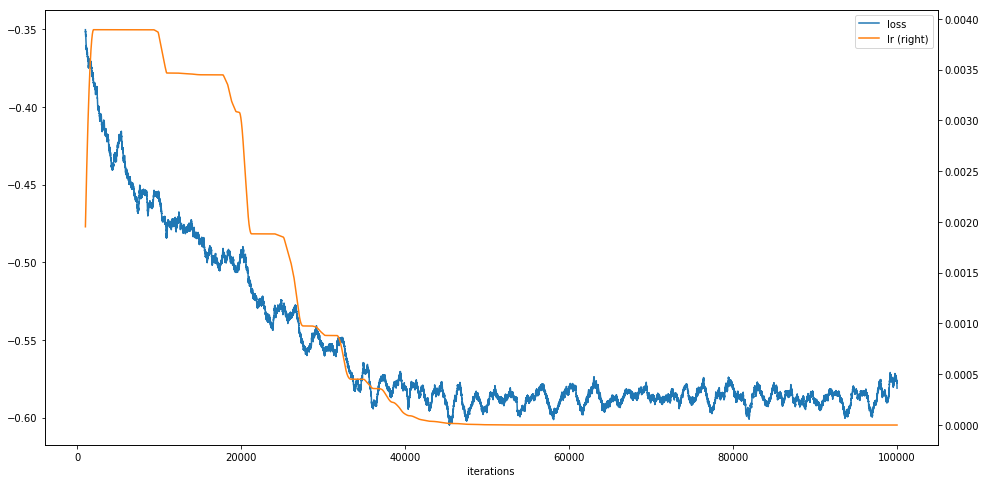

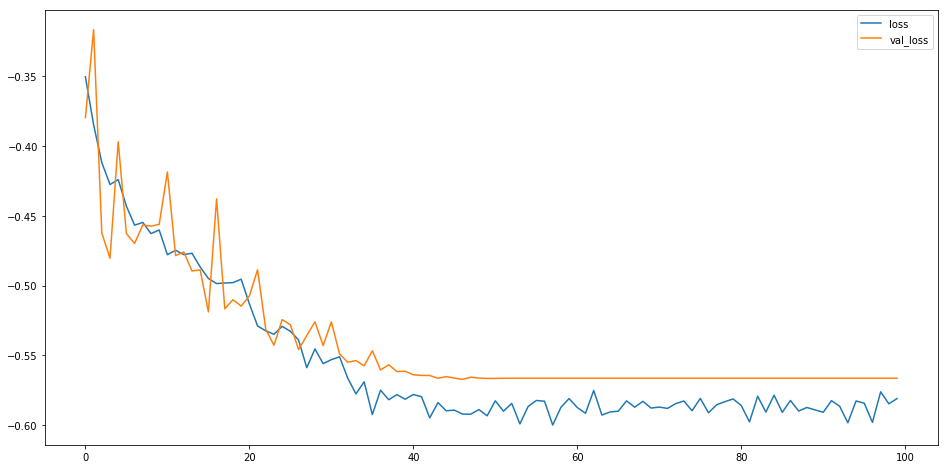

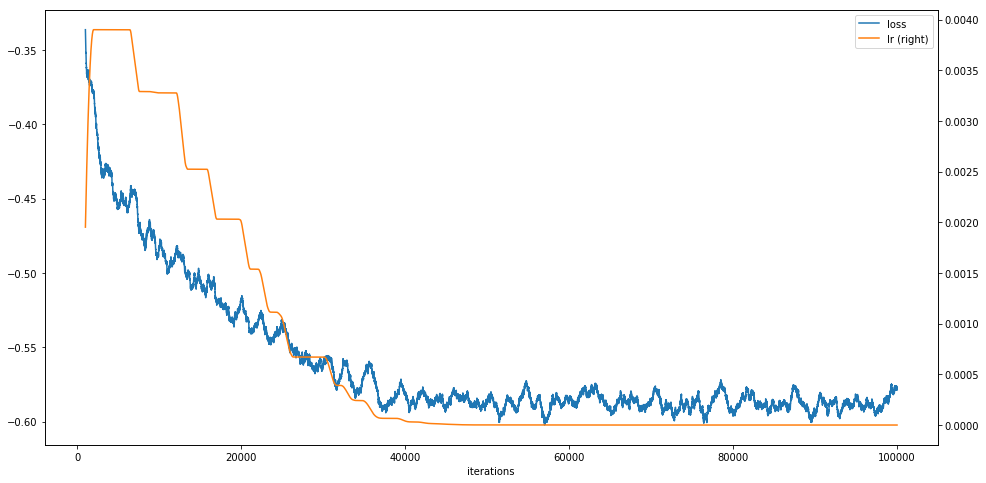

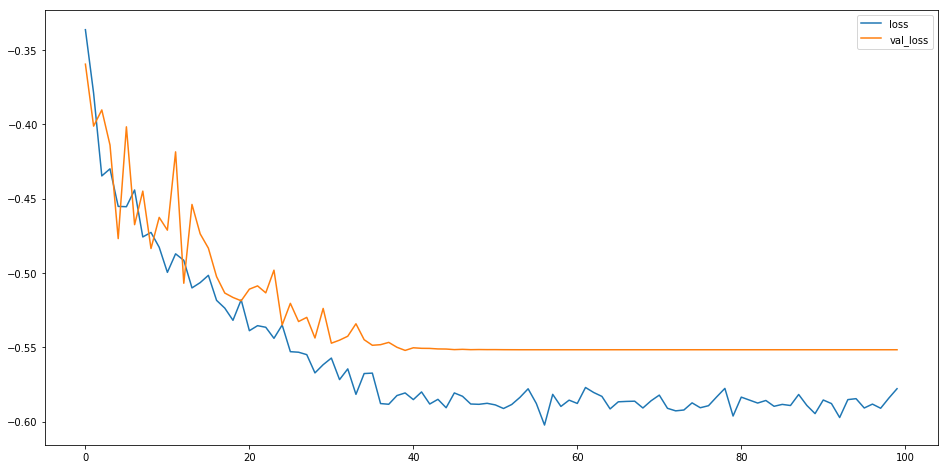

In [21]:
train_oof((votes, answers), votes_test)